# Práctica 2: Implementación de Algoritmos de Procesamiento de Imágenes

#### Pablo Chantada Saborido
pablo.chantada@udc.es

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import skimage.data as data

# Usamos la imagen Camera como ejemplo de la aplicación de los filtros 
img = data.camera()


## Filtrado Espacial - Suavizado Gaussiano 1D

La función `gaussianFilterSpatial1D(sigma)` genera un kernel gaussiano unidimensional con un parámetro de suavizado $\sigma$. Este kernel se utiliza para aplicar un filtro de suavizado en el dominio espacial de una imagen.

__Parámetros:__
- `sigma`: Controla el ancho del filtro y la cantidad de suavizado. A mayor valor de $\sigma$, el filtro será más amplio y el efecto de suavizado será mayor.

__Implementación:__
1. Calculamos el tamaño del kernel, __N__, como:

   $$
   N = 2 \times \lceil 3\sigma \rceil + 1
   $$

   Esto asegura que el kernel tenga un tamaño suficiente para capturar la mayor parte de la forma de la función gaussiana.

2. Calculamos el centro de la gaussiana, $x = 0 $, situado en la posición:

   $$
   \text{center} = \left\lfloor \frac{N}{2} \right\rfloor
   $$

   No utilizamos $\left\lfloor \frac{N}{2} \right\rfloor + 1$, ya que los índices en Python comienzan en 0, lo que nos daria un indice incorrecto.

3. Rellenamos el kernel utilizando la función de la gaussiana:

   $$
   \text{kernel}[x] = e^{-\frac{(x - \text{center})^2}{2\sigma^2}}
   $$

4. Normalizamos el kernel para que la suma de sus valores sea 1, evitando pérdidas de luminosidad o intensidad:

   $$
   \text{kernel} = \frac{\text{kernel}}{\sum \text{kernel}}
   $$


In [2]:
def gaussianFilterSpatial1D(sigma):
    
    N = int(2 * np.ceil(3 * sigma) + 1)
    center = (N // 2)  # No usamos (N // 2) + 1 ya  que los indices de python comienzan en 0
    kernel = np.zeros(N)
    
    # Rellenar el kernel con la formula
    for x in range(N):
        kernel[x] = np.exp(-((x - center) ** 2) / (2 * (sigma ** 2)))

    # Normaliza el kernel para que la suma sea 1
    kernel /= np.sum(kernel)

    return kernel

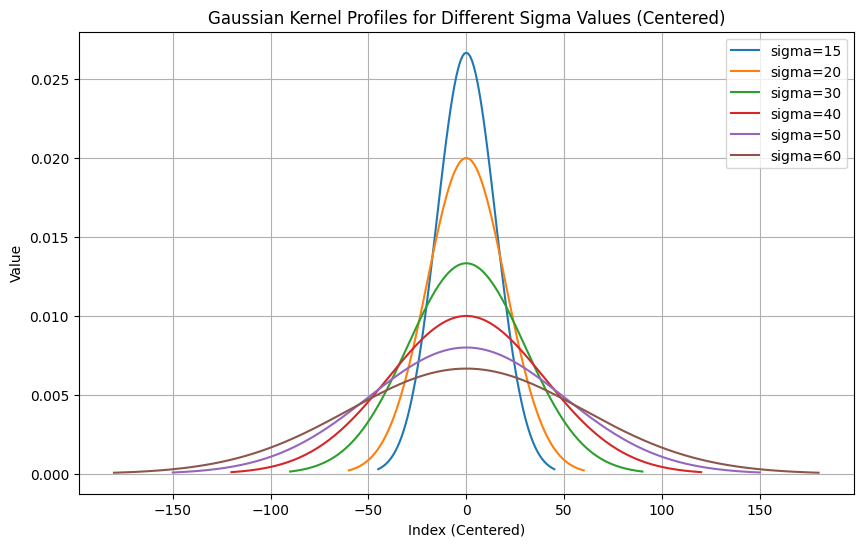

In [3]:
sigmas = [15, 20, 30, 40, 50, 60]  # Lista de diferentes valores de sigma
plt.figure(figsize=(10, 6))

# Generamos y graficamos el perfil Gaussiano para cada sigma
for sigma in sigmas:
    kernel = gaussianFilterSpatial1D(sigma)
    center_index = len(kernel) // 2  # Índice central del kernel
    x_values = np.arange(-center_index, center_index + 1)  # Crear eje x centrado
    plt.plot(x_values, kernel, label=f"sigma={sigma}")

# Configuramos los detalles de la gráfica
plt.title("Gaussian Kernel Profiles for Different Sigma Values (Centered)")
plt.xlabel("Index (Centered)")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()


## Filtrado Espacial - Suavizado Gaussiano 2D

La función `ApplyGaussianFilterSpatial(inImage, sigma)` aplica un filtro Gaussiano bidimensional sobre la imagen de entrada `inImage` usando un filtro de tamaño $N \times N$ con un parámetro $\sigma$.

__Parámetros:__
- `inImage`: Imagen de entrada sobre la cual se aplicará el suavizado.
- `sigma`: Controla el grado de suavizado, influenciando el tamaño del kernel.

__Implementación:__
1. Calculamos el tamaño del kernel, __N__, de la misma forma que en la función unidimensional:

   $$
   N = 2 \times \lceil 3\sigma \rceil + 1
   $$

2. Aprovechando la propiedad de separabilidad del filtro Gaussiano, aplicamos primero un kernel unidimensional $1 \times N$ a las filas de la imagen y luego su transpuesto $N \times 1$ a las columnas.

3. Como resultado obtenemos una imagen suavizada en la que se han atenuado los detalles, pudiendo observar aun la imagen original.

In [4]:
def ApplyGaussianFilterSpatial(inImage, sigma):
    conv = gaussianFilterSpatial1D(sigma)
    # Usar apply_along_axis  para aplicar a las filas la funcion
    img = np.apply_along_axis(lambda x: np.convolve(x, conv, mode="same"), axis=1, arr=inImage)
    # Aplicar otra vez para las columnas
    filter = np.apply_along_axis(lambda x: np.convolve(x, conv, mode="same"), axis=0, arr=img) 
    return filter, (conv, img)

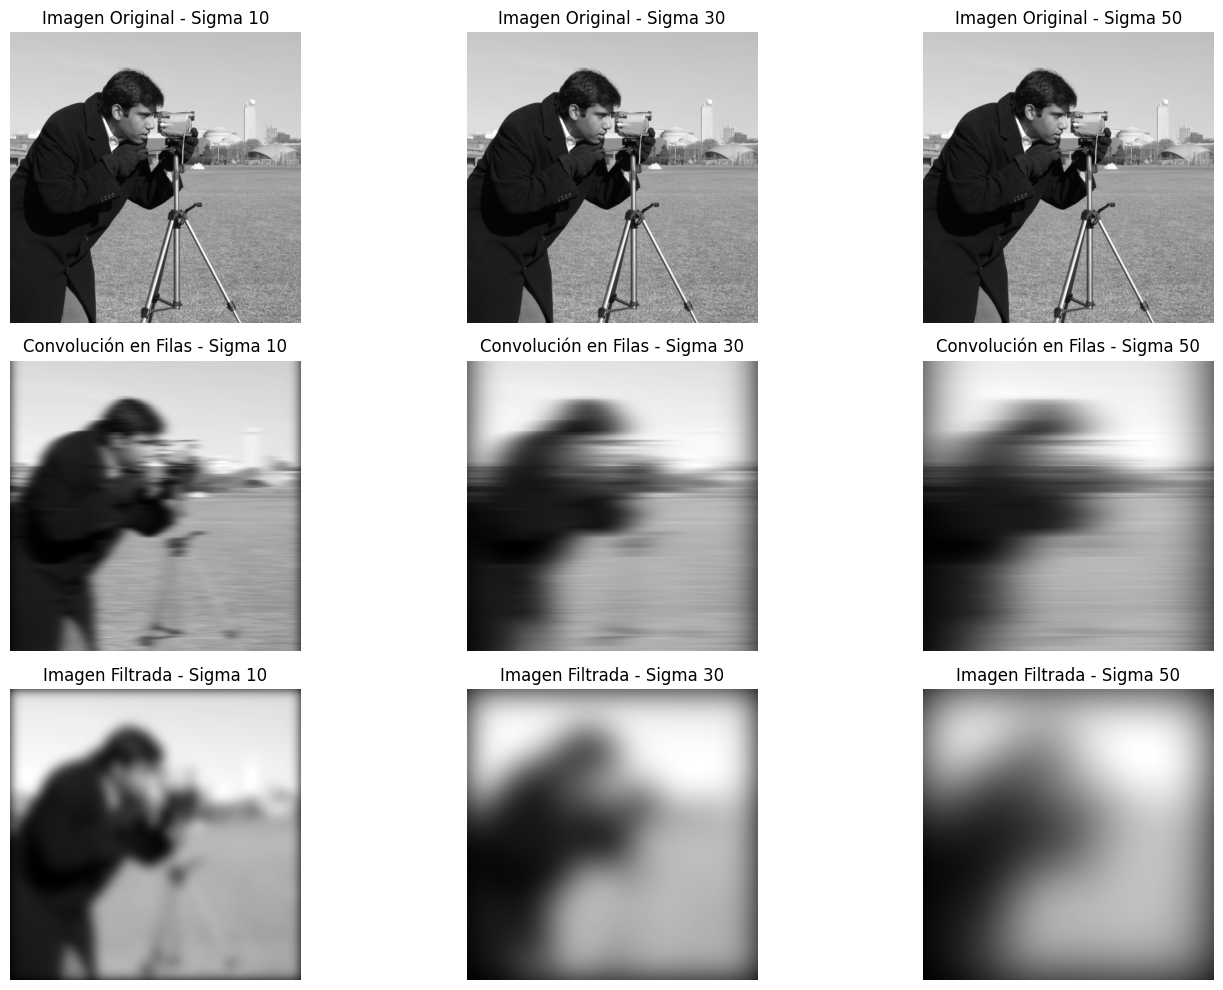

In [5]:
sigmas = [10, 30, 50]

# Creamos los subplots para visualizar cada paso
fig, axes = plt.subplots(3, len(sigmas), figsize=(15, 10))

for i, sigma in enumerate(sigmas):
    # Aplicamos el filtro Gaussiano bidimensional
    filtered_image, (conv, intermediate_image) = ApplyGaussianFilterSpatial(img, sigma)
    
    # Imagen original
    axes[0, i].imshow(img, cmap='gray')
    axes[0, i].set_title(f'Imagen Original - Sigma {sigma}')
    axes[0, i].axis('off')

    # Resultado de la convolución en las filas (intermedio)
    axes[1, i].imshow(intermediate_image, cmap='gray')
    axes[1, i].set_title(f'Convolución en Filas - Sigma {sigma}')
    axes[1, i].axis('off')

    # Imagen final filtrada (después de la convolución en columnas)
    axes[2, i].imshow(filtered_image, cmap='gray')
    axes[2, i].set_title(f'Imagen Filtrada - Sigma {sigma}')
    axes[2, i].axis('off')

plt.tight_layout()
plt.show()



## Filtrado en Frecuencia - Generación del Filtro Gaussiano

La función `gaussianFilterFrec(inImage, sigma)` calcula un filtro gaussiano en el dominio de frecuencia con dimensiones iguales a las de la imagen de entrada `inImage` y un parámetro de suavizado $\sigma$.

__Parámetros:__
- `inImage`: Imagen de entrada utilizada para definir el tamaño del filtro.
- `sigma`: Controla el ancho de la gaussiana y la cantidad de suavizado en el dominio de frecuencia.

__Detalles de implementación:__
1. Obtenemos el tamaño de la imagen.

2. Calculamos la Transformada de Fourier bidimensional de `inImage` usando `np.fft.fft2` y la centramos con `np.fft.fftshift`, trasladando las frecuencias bajas al centro.

3. Generamos coordenadas centradas en el origen (equivalente a `center` en 1D) y aplicamos la fórmula de la función Gaussiana en 2D:

   $$
   \text{gaussian\_kernel}(x, y) = e^{-\frac{x^2 + y^2}{2 \sigma^2}}
   $$

   La función `np.meshgrid` nos genera las matrices de las coordenadas de `np.linspace` de la siguiente forma:
         $$
         X = \begin{bmatrix}
         -2.5 & -1.25 & 0 & 1.25 & 2.5 \\
         -2.5 & -1.25 & 0 & 1.25 & 2.5 \\
         -2.5 & -1.25 & 0 & 1.25 & 2.5 \\
         \end{bmatrix}
         $$

4. Aplicamos el filtro multiplicando el espectro de frecuencia de la imagen por el filtro gaussiano, lo cual equivale a realizar una convolución en el dominio espacial.

5. Finalmente, usamos `np.fft.ifftshift` y `np.fft.ifft2` para volver al dominio espacial, obteniendo la imagen suavizada.

No precisamos realizar una normalización ya que al aplicar la transformada inversa de Fourier para volver al dominio espacial, la imagen resultante recupera automáticamente su escala correcta

In [6]:
def gaussianFilterFrec(inImage, sigma):
    # Obtenemos las dimensiones
    N, M = inImage.shape
    # Obteneter la transformada de fourier
    dft = np.fft.fft2(inImage)
    img_frec = np.fft.fftshift(dft)
    
    # Crea un filtro gaussiano en el dominio de la frecuencia
    x = np.linspace(-M // 2, M // 2, M)
    y = np.linspace(-N // 2, N // 2, N)
    # Generanmos las matrices de las coordenadas
    X, Y = np.meshgrid(x, y)
    
    # Filtro gaussiano
    gaussian_kernel = np.exp(-(X ** 2 + Y**2) / (2 * sigma ** 2))
    
    # Aplicar el filtro
    filtered_image_frec = img_frec * gaussian_kernel
    
    # Transformada inversa para volver al dominio espacial
    filtered_image = np.fft.ifftshift(filtered_image_frec)
    filtered_image = np.fft.ifft2(filtered_image)
    return np.abs(filtered_image), (np.abs(dft), np.abs(img_frec), np.abs(filtered_image_frec), gaussian_kernel)

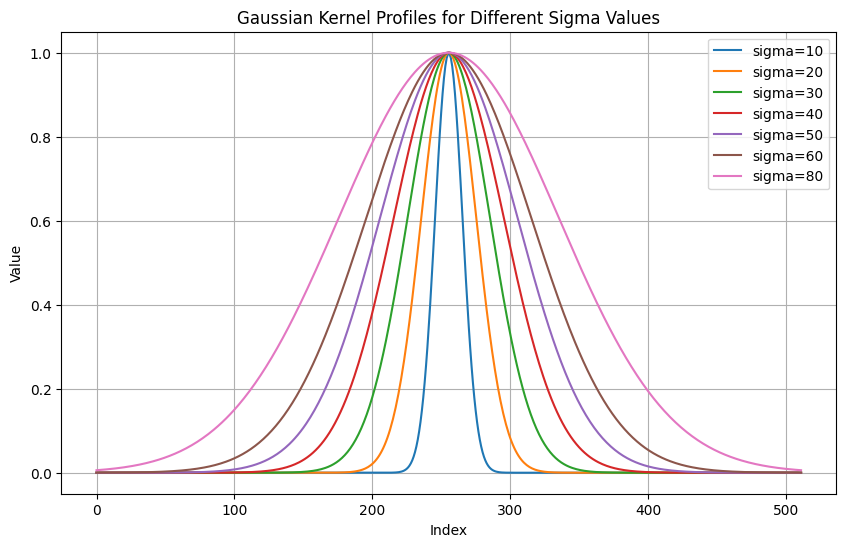

In [ ]:
sigmas = [10, 20, 30, 40, 50, 60, 80]  # Lista de diferentes valores de sigma
plt.figure(figsize=(10, 6))

# Generamos y graficamos el perfil Gaussiano para cada sigma
for sigma in sigmas:
    _, (_, _, _, kernel) = gaussianFilterFrec(img, sigma)
    center_row = kernel[kernel.shape[0] // 2, :]  # Perfil central del kernel
    plt.plot(center_row, label=f"sigma={sigma}")

# Configuramos los detalles de la gráfica
plt.title("Gaussian Kernel Profiles for Different Sigma Values")
plt.xlabel("Index")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()


## Filtrado en Frecuencia - Aplicación del Filtro Gaussiano

La función `ApplyGaussianFilterFrec(inImage, sigma)` aplica el filtro Gaussiano previamente generado sobre la imagen de entrada `inImage` en el dominio de frecuencia, permitiendo suavizar la imagen mediante la atenuación de las altas frecuencias.

__Parámetros:__
- `inImage`: Imagen de entrada que será suavizada.
- `sigma`: Controla el ancho de la gaussiana y, por lo tanto, la intensidad del suavizado en el dominio de frecuencia.

__Detalles de implementación:__

Como los cálculos de la transformada de Fourier, el centrado (`np.fft.fftshift`), la generación del filtro gaussiano, y la transformación inversa (`np.fft.ifft2` y `np.fft.ifftshift`) ya se realizan en la función `gaussianFilterFrec`, en esta función solo es necesario obtener la imagen resultante. La función llama a `gaussianFilterFrec` y devuelve directamente la imagen suavizada en el dominio espacial.

In [8]:
def ApplyGaussianFilterFrec(inImage, sigma):
    filtered_image_frec, _ = gaussianFilterFrec(inImage, sigma)
    return filtered_image_frec

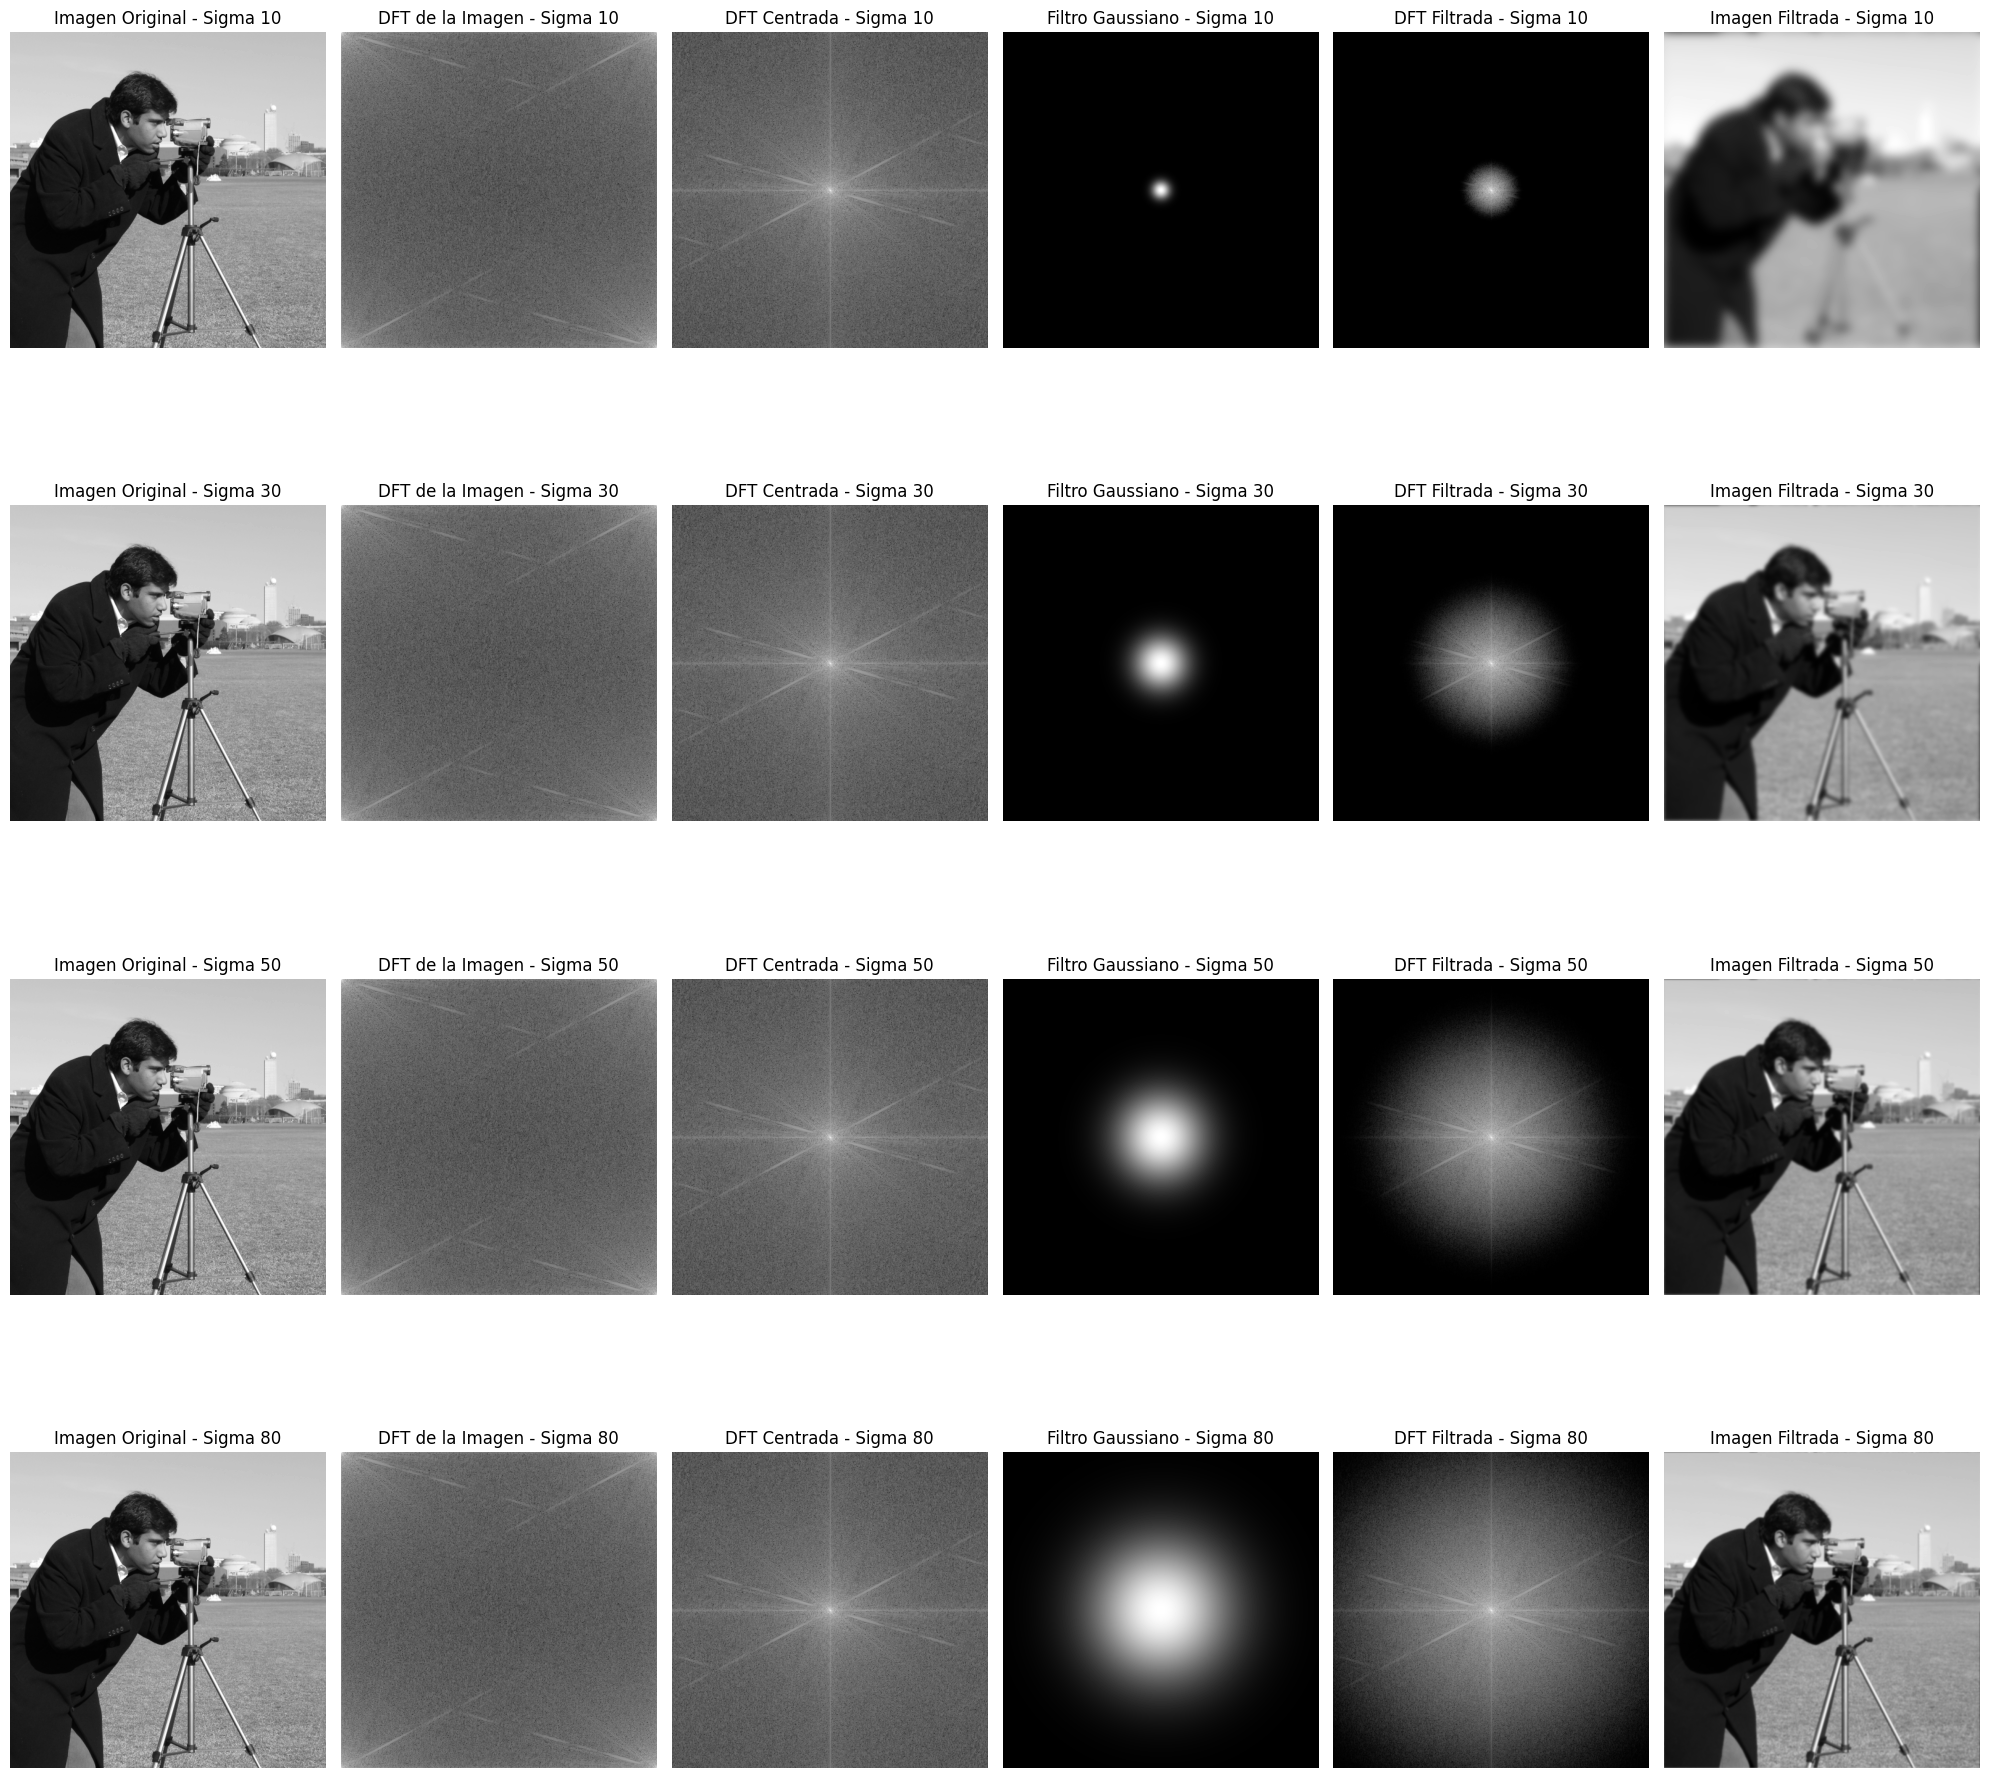

In [9]:
# Lista de valores de sigma
sigmas = [10, 30, 50, 80]

# Creamos los subplots para visualizar cada paso con múltiples sigmas
fig, axes = plt.subplots(len(sigmas), 6, figsize=(20, 5 * len(sigmas)))

for i, sigma in enumerate(sigmas):
    # Llamamos a la función y obtenemos las imágenes intermedias para cada sigma
    filtered_image, (dft, img_frec, filtered_image_frec, gaussian_kernel) = gaussianFilterFrec(img, sigma)
    
    # Imagen Original
    axes[i, 0].imshow(img, cmap='gray')
    axes[i, 0].set_title(f'Imagen Original - Sigma {sigma}')
    axes[i, 0].axis('off')

    # DFT de la Imagen
    axes[i, 1].imshow(np.log(1 + dft), cmap='gray')
    axes[i, 1].set_title(f'DFT de la Imagen - Sigma {sigma}')
    axes[i, 1].axis('off')

    # DFT Centrada
    axes[i, 2].imshow(np.log(1 + img_frec), cmap='gray')
    axes[i, 2].set_title(f'DFT Centrada - Sigma {sigma}')
    axes[i, 2].axis('off')

    # Filtro Gaussiano en Dominio de Frecuencia
    axes[i, 3].imshow(gaussian_kernel, cmap='gray')
    axes[i, 3].set_title(f'Filtro Gaussiano - Sigma {sigma}')
    axes[i, 3].axis('off')

    # DFT Filtrada
    axes[i, 4].imshow(np.log(1 + filtered_image_frec), cmap='gray')
    axes[i, 4].set_title(f'DFT Filtrada - Sigma {sigma}')
    axes[i, 4].axis('off')

    # Imagen Final Filtrada en el Dominio Espacial
    axes[i, 5].imshow(filtered_image, cmap='gray')
    axes[i, 5].set_title(f'Imagen Filtrada - Sigma {sigma}')
    axes[i, 5].axis('off')

# Ajuste de layout para evitar superposición de títulos y etiquetas
plt.tight_layout()
plt.show()


# Comparativa del Filtro Gaussiano en el Dominio Espacial vs. el Dominio de la Frecuencia

El filtro gaussiano es utilizado para suavizar o desenfocar una imagen. Sin embargo, el efecto del filtro gaussiano varía según el dominio en el que se aplique: __espacial__ o __frecuencia__.

## 1. Filtro Gaussiano en el Dominio Espacial

En el dominio espacial, el filtro gaussiano se aplica directamente sobre los píxeles de la imagen utilizando un __kernel__ gaussiano. Este kernel realiza una convolución, lo que significa que calcula un promedio ponderado de los píxeles vecinos.

- __Sigma bajo__: el kernel gaussiano es estrecho, lo que significa que tiene en cuenta menos píxeles vecinos. Esto resulta en un __menor desenfoque__.
- __Sigma alto__: el kernel gaussiano es más ancho, cubriendo más píxeles alrededor del objetivo. Esto provoca un __mayor desenfoque__ ya que se toman en cuenta más valores en el promedio.

## 2. Filtro Gaussiano en el Dominio de la Frecuencia

En el dominio de la frecuencia, la imagen se transforma mediante la __Transformada de Fourier__ para representar las frecuencias que componen la imagen. El filtro gaussiano actúa como un __filtro paso bajo__ en este caso.

- __Sigma bajo__: el filtro gaussiano en la frecuencia tiene un área de efecto pequeña, bloqueando las frecuencias altas (detalles y bordes), lo que genera un __efecto de desenfoque fuerte__ en la imagen.
- __Sigma alto__: el filtro gaussiano es más amplio en el dominio de la frecuencia, permitiendo que pasen más frecuencias altas y bloqueando menos detalles. Esto produce un __desenfoque menor__.

## Comparativa

| Dominio                      | Sigma Bajo                               | Sigma Alto                                 |
|------------------------------|------------------------------------------|--------------------------------------------|
| __Espacial__                 | Menor desenfoque                         | Mayor desenfoque                           |
| __Frecuencia__               | Mayor desenfoque                         | Menor desenfoque                           |

## Conclusión

La diferencia en el comportamiento del filtro gaussiano en ambos dominios radica en la manera en la que afectan la imagen:

- En el __dominio espacial__, un sigma alto significa un kernel más amplio, lo que genera mayor desenfoque.
- En el __dominio de la frecuencia__, un sigma alto significa que el filtro deja pasar más frecuencias altas, generando menos desenfoque.